**SOW-MKI49: Neural Information Processing Systems**  
*Weeks 2 and 3: Assignment (200 points + 20 bonus points + 1 bonus point for each bug you find and another bonus point if you debug it and before you ask, no, typos unfortunately are not considered bugs - first come, first served)*  
Author: Umut

In [0]:
# Group 17: ...
# Sameera Sandaruwan - s1014012
# Student 2 name, student 2 number: ...
# Student 3 name, student 3 number: ...

# To Do List
1. add_persistant problem when loading Vgg4 model .npz file
2. 

In [2]:
batch_size = 4
data_directory = 'Data' # Make a directory to store the data and enter it here.
                    # We will be using a smaller dataset (LFW) than the one used in the paper (CelebA) for computational resource considerations.
                    # Download it from http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz.
device = 0 #sameera GPU
epochs = 100
lambda_ = {'feature': 1., 'pixel': 1., 'total_variation': 1e-5}
model_directory = 'Model' # Make a directory to store the models and enter it here. Move Vgg4Layers.npz to the model directory.
outsize = (96, 96)

**Packages (10 points)**  
In this cell, you will import the required packages.  
*Tasks*   
- (1) It is always good practice to first think about the big picture and not rush into writing code before clearly knowing everything that you will have to do so as to avoid future complications. Therefore, your first task is to study the skeleton code and come up with a plan of how to proceed. (**0 points**)
- (2) However, I agree that doing so is arguably the most boring part of coding, and you rather skip it. To help you to resist the temptation of skipping going through the skeleton code, I have removed the import statements. Your second task is to Identify the required packages and import them. Note that if you are using Python 2.7, you should import print from the future. (**10 points**)

In [3]:
# (2) start
# numpy, cv2, pillow, chainer, scikit-image, glob, os
import numpy as np
import cv2
from PIL import Image
import os
from matplotlib import pyplot as plt
%matplotlib inline
# (2) end

In [4]:
import chainer
from chainer import Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, serializers, dataset
from chainer import Link, Chain, ChainList
from chainer.optimizers import Adam
from chainer.dataset import concat_examples
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

In [ ]:
from chainer.backends import cuda

**Preprocessing functions (10 points + 5 bonus points)** (taken from https://github.com/mbeyeler/opencv-python-blueprints)  
In the following cell, you will implement some of the preprocessing functions. The rest of the preprocessing steps have already been applied to the data.  
*Tasks*
- (1) Implement the resizing operation. That is, you should extract the data, resize each portrait to 96 pixels x 96 pixels and save them to the data directory as JPG. (**10 points **)
- (2) The pencil sketch class implements the sketch effect in a simpler way than the one mentioned in the lecture. Explain how/why the used operations (blur and divide) convert portraits to sketches, and how it differs from that which was mentioned in the lecture? (**5 bonus points**)

- get directory list from Data folder
- count empyt folders
- count all data

In [21]:
# Open all images
all_folders_in_Data = sorted(os.listdir(data_directory))
for n in range(2):
    celebs = sorted(os.listdir(os.path.join(data_directory, all_folders_in_Data[n])))
    for celeb_name in celebs:
        im = Image.open(os.path.join(data_directory, all_folders_in_Data[n], celeb_name))
        im.show()

In [5]:
# (1) start
# .
# .
# .
# (1) end

class PencilSketch:
    """Pencil sketch effect
        A class that applies a pencil sketch effect to an image.
    """

    def __init__(self, width, height): #ERROR: can't have () here --> def __init__(self, (width, height)):
        """Initialize parameters
            :param (width, height): Image size.
        """
        self.width = width
        self.height = height

        ### ERROR: useless
        # try to open background canvas (if it exists)
        #self.canvas = cv2.imread(bg_gray, cv2.CV_8UC1)
        #if self.canvas is not None:
            #self.canvas = cv2.resize(self.canvas, (self.width, self.height))

    def render(self, img_rgb):
        """Applies pencil sketch effect to an RGB image
            :param img_rgb: RGB image to be processed
            :returns: Processed RGB image
        """
        img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        img_blur = cv2.GaussianBlur(img_gray, (21, 21), 0, 0)
        img_blend = cv2.divide(img_gray, img_blur, scale=256)

        # return cv2.cvtColor(img_blend, cv2.COLOR_GRAY2RGB)
        return img_blend

def pencil_sketch(img_rgb):
    pencilSketch = PencilSketch(img_rgb.shape[1], img_rgb.shape[0])

    return pencilSketch.render(img_rgb)

# (2) Write your answer here.

#find out what this is
def preprocess(img):
    if img.mode == 'L':
        return np.rollaxis(np.asarray(img, 'float32')[..., None], 2)
    else:
        return np.rollaxis(np.asarray(img, 'float32')[..., ::-1], 2)

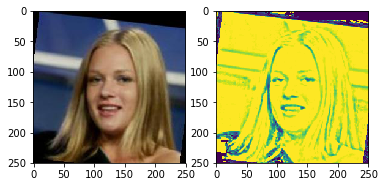

In [5]:

# Open all images
all_folders_in_Data = sorted(os.listdir(data_directory))
for n in range(1):
    celebs = sorted(os.listdir(os.path.join(data_directory, all_folders_in_Data[n])))
    for celeb_name in celebs:
        im = cv2.imread(os.path.join(data_directory, all_folders_in_Data[n], celeb_name))
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        sketch_img = pencil_sketch(im)
        plt.subplot(121)
        plt.imshow(im)
        plt.subplot(122)
        plt.imshow(sketch_img)

**Data class**  
The following cell defines the data class. It is used to manage the data (loading, etc.). *You do not have to make any changes to the code.*  
*Task*
- (1) Study the code and refer to the chainer docuimentation if anything is unclear. You will be expected to write similar code by yourself in the coming practicals. (**0 points**)

In [6]:
class Dataset(dataset.DatasetMixin):
    def __init__(self, data_files):
        self.data_files = data_files

    ## ERROR: indentation problem was here
    def __len__(self):
        return len(self.data_files)

    def get_example(self, i):
        t = np.asarray(Image.open(self.data_files[i]).convert('RGB').resize((96, 96), Image.LANCZOS), 'f').transpose(2, 0, 1)
        x = pencil_sketch(np.asarray(Image.open(self.data_files[i]).convert('RGB').resize((96, 96), Image.LANCZOS)))[None]
    
        return t, x #t-target (realistic img), x-input(sketch img)

**Model classes (45 points)**  
In the following cell you will implement the model classes.
*Tasks*   
- (1) Implement the layers of the model by filling in the missing code. (**20 points**)
- (2) Reimplement the model as a ChainList instead of a Chain. (**5 points**)
- (3) Implement the forward pass of the residual block by filling in the missing code. (**20 points**)

# Notes
### https://docs.chainer.org/en/stable/glance.html
### https://docs.chainer.org/en/stable/guides/index.html
### https://docs.chainer.org/en/stable/reference/index.html
- what are in_channels, out_channels
- wht Functions and Links
- param of Convolution2D

- what is parsing X = X is the input to the network
- Chain class = In order to make it more reusable, we want to support parameter management, CPU/GPU migration, robust and flexible save/load features, etc. These features are all supported by the "Chain" class in Chainer.
- __call__ = We often define a single forward method of a link by the __call__ operator. Such links and chains are callable and behave like regular functions of Variables.
- super = Inheritance
class Animal:
  def __init__(self, animalName):
    print(animalName, 'is an animal.');

class Mammal(Animal):
  def __init__(self, mammalName):
    print(mammalName, 'is a warm-blooded animal.')
    super().__init__(mammalName)
    
class NonWingedMammal(Mammal):
  def __init__(self, NonWingedMammalName):
    print(NonWingedMammalName, "can't fly.")
    super().__init__(NonWingedMammalName)

class NonMarineMammal(Mammal):
  def __init__(self, NonMarineMammalName):
    print(NonMarineMammalName, "can't swim.")
    super().__init__(NonMarineMammalName)

class Dog(NonMarineMammal, NonWingedMammal):
  def __init__(self):
    print('Dog has 4 legs.');
    super().__init__('Dog')
    
d = Dog()
print('')
bat = NonMarineMammal('Bat') 

- self.init_scope() = A child link can be added just by assigning it to an attribute of the chain within init_scope().

The registered child link is saved and loaded on serialization and deserialization, and involved in the optimization. The registered link is called a child. 

- Links = Building block of model definitions.
- Chain = Composable link with object-like interface.
- ChainList = Composable link with list-like interface.

In [6]:
class LeNet5(Chain):
    def __init__(self):
        super(LeNet5, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=1, out_channels=6, ksize=5, stride=1)
            self.conv2 = L.Convolution2D(in_channels=6, out_channels=16, ksize=5, stride=1)
            self.conv3 = L.Convolution2D(in_channels=16, out_channels=120, ksize=4, stride=1)
            self.fc4 = L.Linear(None, 84)
            self.fc5 = L.Linear(84, 10)

    def __call__(self, x):
        h = F.sigmoid(self.conv1(x))
        h = F.max_pooling_2d(h, 2, 2)
        h = F.sigmoid(self.conv2(h))
        h = F.max_pooling_2d(h, 2, 2)
        h = F.sigmoid(self.conv3(h))
        h = F.sigmoid(self.fc4(h))
        if chainer.config.train:
            return self.fc5(h)
        return F.softmax(self.fc5(h))

In [7]:
class Model(Chain):
    def __init__(self, in_channels, outsize):
        super(Model, self).__init__()
        ''' just inicializing different layers (Links [L]) '''
        with self.init_scope():
            # (1) start
            # convolution2D_0 = ...
            self.convolution2D_0 = L.Convolution2D(in_channels=3, out_channels=32, 
                                                   ksize=9, stride=1, pad=4)
            # batchNormalization_0 = ...
            self.batchNormalization_0 = L.BatchNormalization(32)
            # convolution2D_1 = ...
            self.convolution2D_1 = L.Convolution2D(in_channels=32, out_channels=64, 
                                                   ksize=3, stride=2, pad=1)
            # batchNormalization_1 = ...
            self.batchNormalization_1 = L.BatchNormalization(64)
            # convolution2D_2 = ...
            self.convolution2D_2 = L.Convolution2D(in_channels=64, out_channels=128, 
                                                   ksize=3, stride=2, pad=1)
            # batchNormalization_2 = ...
            self.batchNormalization_2 = L.BatchNormalization(128)
        
            
            # residualBlock_3 = ...
            self.residualBlock_3 = ResidualBlock(128, 128)
            # residualBlock_4 = ...
            self.residualBlock_4 = ResidualBlock(128, 128)
            # residualBlock_5 = ...
            self.residualBlock_5 = ResidualBlock(128, 128)
            # residualBlock_6 = ...
            self.residualBlock_6 = ResidualBlock(128, 128)
            # residualBlock_7 = ...
            self.residualBlock_7 = ResidualBlock(128, 128)
            
            # deconvolution2D_8 = ...
            self.deconvolution2D_8 = L.Deconvolution2D(in_channels=128, out_channels=64, 
                                                       ksize=3, stride=2, pad=1, nobias=True, outsize=outsize)
            # batchNormalization_8 = ...
            self.batchNormalization_8 = L.BatchNormalization(64)
            # (1) end
            self.deconvolution2D_9 = L.Deconvolution2D(64, 32, 3, 2, 1, True, outsize)
            self.batchNormalization_9 = L.BatchNormalization(32)
            self.convolution2D_10 = L.Convolution2D(32, 3, 9, stride=1, pad = 4, nobias = True)
            self.batchNormalization_10 = L.BatchNormalization(3)

        self.in_channels = in_channels
        self.outsize = outsize

    def __call__(self, x, finetune = False):
        ''' creating the model using the defined 
        layers and arranging them sequencially. (Functions [F])'''
        h = self.convolution2D_0(x)
        h = self.batchNormalization_0(h, finetune)
        h = F.relu(h)
        h = self.convolution2D_1(h)
        h = self.batchNormalization_1(h, finetune)
        h = F.relu(h)
        h = self.convolution2D_2(h)
        h = self.batchNormalization_2(h, finetune)
        h = F.relu(h)
        h = self.residualBlock_3(h, finetune)
        h = self.residualBlock_4(h, finetune)
        h = self.residualBlock_5(h, finetune)
        h = self.residualBlock_6(h, finetune)
        h = self.residualBlock_7(h, finetune)
        h = self.deconvolution2D_8(h)
        h = self.batchNormalization_8(h, finetune)
        h = F.relu(h)
        h = self.deconvolution2D_9(h)
        h = self.batchNormalization_9(h, finetune)
        h = F.relu(h)
        h = self.convolution2D_10(h)
        h = self.batchNormalization_10(h, finetune)
        y = 127.5 * F.tanh(h) + 127.5 # QQQ: what is this

        return y

# Another way to define a chain is using the ChainList class, 
# which behaves like a list of links:
class ModelCL(ChainList):
    # (2) start
    def __init__(self, in_channels, outsize):
        # super init is the difference in ChainList
        super(ModelCL, self).__init__(
            L.Convolution2D(in_channels=3, out_channels=32, ksize=9, stride=1, pad=4),#0
            L.BatchNormalization(32),#1
            L.Convolution2D(in_channels=32, out_channels=64, ksize=3, stride=2, pad=1),#2
            L.BatchNormalization(64),#3
            L.Convolution2D(in_channels=64, out_channels=128, ksize=3, stride=2, pad=1),#4
            L.BatchNormalization(128),#5
            ResidualBlock(128, 128),#6
            ResidualBlock(128, 128),#7
            ResidualBlock(128, 128),#8
            ResidualBlock(128, 128),#9
            ResidualBlock(128, 128),#10
            L.Deconvolution2D(in_channels=128, out_channels=64, ksize=3, stride=2, pad=1, nobias=True, 
                              outsize=outsize),#11
            L.BatchNormalization(64),#12
            L.Deconvolution2D(64, 32, 3, 2, 1, True, outsize),#13
            L.BatchNormalization(32),#14
            L.Convolution2D(32, 3, 9, pad = 4, nobias = True),#15
            L.BatchNormalization(3)#16
        )
        
        self.in_channels = in_channels
        self.outsize = outsize

    def __call__(self, x, finetune = False):
        ''' creating the model using the defined 
        layers and arranging them sequencially. (Functions [F])'''
        h = self[0](x)
        h = self[1](h, finetune)
        h = F.relu(h)
        h = self[2](h)
        h = self[3](h, finetune)
        h = F.relu(h)
        h = self[4](h)
        h = self[5](h, finetune)
        h = F.relu(h)
        h = self[6](h, finetune)
        h = self[7](h, finetune)
        h = self[8](h, finetune)
        h = self[9](h, finetune)
        h = self[10](h, finetune)
        h = self[11](h)
        h = self[12](h, finetune)
        h = F.relu(h)
        h = self[13](h)
        h = self[14](h, finetune)
        h = F.relu(h)
        h = self[15](h)
        h = self[16](h, finetune)
        y = 127.5 * F.tanh(h) + 127.5

        return y
    # (2) end

'''
Questions:
1. nobias = for neurons no bias variable (b) form (W,b)
2. pad ??
3. 
'''    
    
class ResidualBlock(Chain):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        with self.init_scope():
            self.convolution2D_0 = L.Convolution2D( in_channels, out_channels, ksize=3, 
                                                   stride=1, pad = 1, nobias = True)
            self.batchNormalization_0 = L.BatchNormalization(out_channels)
            self.convolution2D_1 = L.Convolution2D(out_channels, out_channels, ksize=3, 
                                                   stride=1, pad = 1, nobias = True)
            self.batchNormalization_1 = L.BatchNormalization(out_channels)
        
        self.in_channels = in_channels
        self.out_channels = out_channels

    def __call__(self, x, finetune = False):
        # (3) start - configuraiton might be different here
        h = self.convolution2D_0(x)
        h = self.batchNormalization_0(h, finetune)
        h = F.relu(h)
        h = self.convolution2D_1(h)
        h = self.batchNormalization_1(h, finetune)
        y = h+x # no activation is used; as for the paper
        # (3) start

        return y

**Loss classes (45 points)**  
In the following cell, you will implement the loss classes.  
*Tasks*  
- (1) You are provided with a custom VGG-16 implementation. How does it differ than the original implementation? Why can we get away with using the simpler implementation? (**5 points**)
- (2) Implement the missing convolution layer of the total variation loss by filling in the missing code. (**10 points**)
- (3) Implement the forward pass of the total variation loss by filling in the missing code. (**10 points**)
- (4) Implement the feature loss component in the forward pass of the loss function by filling in the missing code. (**10 points**)
- (5) Explain why the loss components are scaled. (**5 points**)
- (6) Explain why the target features are extracted in test mode. (**5 points**)

In [8]:
class Vgg4Layers(Chain):
    def __init__(self):
        super(Vgg4Layers, self).__init__()

        with self.init_scope():
            self.conv1_1 = L.Convolution2D(  3,  64, 3, pad = 1)
            self.conv1_2 = L.Convolution2D( 64,  64, 3, pad = 1)
            self.conv2_1 = L.Convolution2D( 64, 128, 3, pad = 1)
            self.conv2_2 = L.Convolution2D(128, 128, 3, pad = 1)
        #wht is this - adding a persistent value
        #self.add_persistent('mean', np.array([[[[103.939]],[[116.779]],[[ 123.68]]]], dtype='float32'))
        self.mean = np.array([[[[103.939]],[[116.779]],[[ 123.68]]]], dtype='float32')

    def __call__(self, x):
        #broadcast_to = Broadcast a given variable to a given shape.
        h = x - F.broadcast_to(self.mean, x.shape)
        h = self.conv1_1(h)
        h = F.relu(h)
        h = self.conv1_2(h)
        h = F.relu(h)
        h = F.max_pooling_2d(h, 2, 2)
        h = self.conv2_1(h)
        h = F.relu(h)
        h = self.conv2_2(h)
        y = F.relu(h)

        return y


In [8]:
zzz = np.array([3 * [[[-1], [1]]]], 'float32')
print(zzz)
print(zzz.shape)

[[[[-1.]
   [ 1.]]

  [[-1.]
   [ 1.]]

  [[-1.]
   [ 1.]]]]
(1, 3, 2, 1)


In [17]:
# 1. Total Variation Loss
# 2. feature loss
'''
How 2x2 kernal convolution produce the total variation loss
how kernal values are initialized
how does the 2x2 kernal convolution operation accomplish the total variation loss given in the eqn. Does the 2 layer
struct. help with that.

'''
class TotalVariationLoss(Chain):
    def __init__(self):
        super(TotalVariationLoss, self).__init__()
        with self.init_scope():
            self.convolution2D_0 = L.Convolution2D(in_channels=3, out_channels=1, ksize=2, nobias=True, initialW=np.array([3 * [[[-1], [1]]]], 'float32'))
            # (2) start
            self.convolution2D_1 = L.Convolution2D(in_channels=1, out_channels=1, ksize=2, nobias=True, initialW=np.array([1 * [[[-1], [1]]]], 'float32'))
            # (2) end

    def __call__(self, x):
        # (3) start
        # y = ...
        # (3) end
        h = self.convolution2D_0(x)
        h = self.convolution2D_1(h)
        
        return y

    
class LossFunction(object):
    def __init__(self, lambda_):
        self.totalVariationLoss = TotalVariationLoss()
        self.vgg4Layers         = Vgg4Layers()

    def __call__(t, y):            
        with chainer.using_config('train', False):
            t_ = self.vgg4Layers(t)
        # (4) start
        # y_ = ...
            y_ = self.vgg4Layers(y)
        
        '''
        class chainer.links.VGG16Layers(pretrained_model='auto')
        model = chainer.links.VGG16Layers()
        t_hat = model.extract(t, layers = [‘conv2_2’], (96, 96))
        y_hat = model.extract(y, layers = [‘conv2_2’], (96, 96))
        feature_loss = chainer.functions.mean_squared_error(t_hat, y_hat)
        '''
        
        feature_loss = lambda_['feature'] * F.mean_squared_error(t_ , y_)
        # (4) end
        pixel_loss = lambda_['pixel'] * F.mean_squared_error(t , y)
        total_variation_loss = lambda_['total_variation'] * self.totalVariationLoss(t, y)
        loss = feature_loss + pixel_loss + total_variation_loss

        return loss

# (1) Write your answer here.
# (5) Write your answer here.
# (6) Write your answer here.

**Initialization (10 points)**  
The following cell initializes the loss function, the loss history, the model, the optimizer, the datasets and the iterators. *You do not have to make any changes to the code.*  
*Tasks*
- (1) Study the code and refer to the chainer docuimentation if anything is unclear. You will be expected to write similar code by yourself in the coming practicals. (**0 points**)  
- (2) What are the boolean arguments that are passed to the SerialIterator class? (**5 points**)  
- (3) Why is it false for the training iterator but not for other iterators? In other words, what would happen if we were to set it to false for the training iterator and true for the other iterators? (**5 points**)

In [14]:
lossFunction = LossFunction(lambda_)
serializers.load_npz('{:s}/Vgg4Layers.npz'.format(model_directory), lossFunction.vgg4Layers)
loss_history = {'training': [], 'validation': []}
model = Model(3, outsize) if device < 0 else Model(3, outsize).to_gpu(device)
optimizer = Adam() # add param values

optimizer.setup(model)
import glob
data_file = sorted(glob.glob('{}/*/*.jpg'.format(data_directory)))
print(len(data_file))
training_set = Dataset(data_file[:int(.64 * len(data_file))])
validation_set = Dataset(data_file[int(.64 * len(data_file)) : int(.8 * len(data_file))])
test_set = Dataset(data_file[int(.8 * len(data_file)) :])

training_iterator = iterators.SerialIterator(training_set, batch_size, False, True)
validation_iterator = iterators.SerialIterator(validation_set, batch_size, False, False)
test_iterator = iterators.SerialIterator(test_set , batch_size, False, False)

# (2) Write your answer here.
# repeat=False, shuffle=False

# (3) Write your answer here.
# during the training process, it's batches are selected from a shuffled dataset which makes the training more 
# generalized. But if we shuffeld the test and validation data, metrics we use to evaluate the model 
# (accuracy, loss,..) will have much different values due to the shuffel. Hence, using unshuffeled data during test
# validation makes it easier to determine that only training will effect the changes in evaluation metrics.

13233


**Training and validation (20 points)**  
In the following cell, you will train and validate your model.
*Tasks*   
- (1) Implement training loss estimation, backprop and parameter update. (**10 points**)
- (2) Implement validation loss history (**5 points**)
- (3) Implement model serialization  (**5 points**)

In [19]:
aaa_test_set = Dataset(data_file[int(.999 * len(data_file)) :])
aaa_iterator = iterators.SerialIterator(aaa_test_set , batch_size, False, False)
for j, batch in enumerate(aaa_iterator):
    with chainer.using_config('train', False):
        #
        t, x = concat_examples(batch)
        #print(batch.shape)
        print(t.shape)
        print(x.shape)
        print('===============================================')

(4, 3, 96, 96)
(4, 1, 96, 96)
(4, 3, 96, 96)
(4, 1, 96, 96)
(4, 3, 96, 96)
(4, 1, 96, 96)
(2, 3, 96, 96)
(2, 1, 96, 96)


In [0]:
'''
Questions

'''
for i in range(epochs):
    loss_history['training'].append(0)

    for j, batch in enumerate(training_iterator):
        with chaine.using_config('train', True):
            t, x = concat_examples(batch)
            y = model(x)
            # (1) start
            # loss = ...
            # ...
            # ...
            # ...
            # (1) end

        loss_history['training'][-1] += float(loss.data)

    loss_history['training'][-1] /= j + 1
    # (2) start
    # ...

    for j, batch in enumerate(validation_iterator):
        with chaine.using_config('train', False):
            t, x = concat_examples(batch)
            y = model(x)
            loss = lossFunction(t, y)

        # ...

    # ...
    # (2) end
    print('epoch: {:3d} / {:03d}, training loss: {:.4f}, validation loss: {:.4f}.'.format(i + 1, epochs, log['training'], log['validation']))
    np.savez('{:s}/loss_history_{:03d}.npz'.format(model_directory, epoch), loss_history)
    # (3) start
    # ...
    # (3) end
    save_npz('{:s}/optimizer_{:03d}.npz'.format(model_directory, epoch), optimizer)

**Test (45 points + 15 bonus points)**  
In the following cell, you will test your model.  
*Tasks*
- (1) Estimate the test loss, print it and save it. (**15 points**)
- (2) Estimate the validation metrics, print them and save them (tip: scikit-image) (**15 bonus points**)
- (3) Plot example results (i.e., plot a few t, x and y) (**10 points**)
- (4) Dicuss your implementation in 300 - 350 words (e.g., how good your results are, how you can improve your model, etc.) (**20 points**)

In [0]:
# (1), (2) and (3) start
# .
# .
# .
# (1), (2) and (3) end

# (4) Write your answer here.